# Analyse class attendance via Zoom report

Here's how to use this notebook:

![How to use this notebook](using_att_report.pdf)

For instance in the class I built this for, there's a subdirectory under this notebook which has the following files

![Example of how to organize files](organizing_files.png)

-----

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_style('white')

import pandas as pd
import glob
import sys

def load_data(path):
    ''' loads all csv data in path, 
        assumes files naming format is 'zoomus_meeting_report_section_year_month_day.csv' '''     
    if path[-1]!='/':    # make sure path has a trailing slash
        path = path + '/'        
    files = glob.glob(path+'*.csv') # gets all .csv filenames in directory 
    if not files: 
        print('Oops! No csv files in ' + path)
        raise OSError
    else:
        dfs = []
        for afile in files:
            section = afile.split('_')[3]
            date =  pd.Timestamp( '-'.join( afile.split('_')[4:] ).split('.')[0] )
            # print(section,date)
            data = pd.read_csv(afile)
            data['Section'] = section
            data['Date'] = date
            data = data.set_index(['Date','Section','Name'])
            dfs.append( data )   
        results = pd.concat(dfs).sort_index()
        print('Found {} csv files covering {} sections over {} dates in {}'.format(
            len(files), len(results.reset_index().Section.unique()),
            len(results.reset_index().Date.unique()), path ))
        return results

def ind_att(df):
    ''' when students join-then-leave-then-rejoin they get multiple entries in the attendance report 
        this fct is meant to be called on data grouped by Name (plus other vars if desired) and it
        combines the different lines into a single description of the attendance for the student '''
    datadict={}
    datadict['Email'] = df['Email'].max() # doesn't matter which, all should be same
    datadict['Join Time'] = df['Join Time'].min() # first time they arrive
    datadict['Leave Time'] = df['Leave Time'].max() # last time they left
    datadict['Duration(Minutes)'] = df['Duration(Minutes)'].sum() # total of all visits
    # this is how many times the student left and reentered. 
    # maybe use this to figure out which students have bad connections that may hurt their work?  
    datadict['In-n-outs'] = df['Duration(Minutes)'].count()  
    return pd.DataFrame(datadict,index=df.reset_index().Name).drop_duplicates()

def individual_attendance(df):
    ''' calls ind_att to get the work done, handles dataframe cleanup
        the droplevel is because att_report ends up duplicating Name into the index a 2nd time '''
    return ( df
            .groupby(['Date','Section','Name'])
            .apply(ind_att)
            .droplevel(-1) )
    
def section_attendance_report(df):
    '''reports how many people were in each section on each date'''
    return ( individual_attendance(df)
            .groupby([ 'Date','Section'])
            .count()['Join Time'] # join time is never NA, use it for counting
            .rename('Attendees')
            .to_frame() )
    
def individual_date_attendance_report(df):
    '''reports how many dates someone attended; if they do more than 1 section per day (like a TA) they will show up more '''
    return ( individual_attendance(df)
            .groupby(['Name','Date'])
            .count()['Join Time'] # join time is never NA, use it for counting
            .rename('Attendances')
            # we don't care how many sections each day someone went to
            # we just want how many days they attended at least one section; collapse all non-zero to 1
            .apply( lambda x: 1)
            .groupby(['Name']) # now lets count up all the days they were there
            .count()
            .rename('Dates attended')
            .to_frame() )

In [2]:
# if you organized your directory differently, you should change 'Attendance/' to the correct directory location

attendance = load_data('Attendance/')

# obfuscate student info so we can distribute this notebook... don't use in a real situation
#attendance.reset_index(inplace=True)
#attendance['Email']='test@test.edu'
#attendance['Name']=attendance.Name.apply( lambda x: x.split()[0][0]+x.split()[1][0] if len(x.split())>1  else x[0] )
#attendance.set_index(['Date','Section','Name'],inplace=True)

attendance

# NB: I've obfuscated the student information so that I can distribute this notebook to others
# without compromising student privacy
# when you do this you will see the full name and email as the students entered it into Zoom

Found 6 csv files covering 3 sections over 2 dates in Attendance/


Email            Join Time  \
Date       Section Name                                       
2020-01-13 A01     AL    test@test.edu  01/13/2021 09:28:34   
                   AA    test@test.edu  01/13/2021 09:02:26   
                   A     test@test.edu  01/13/2021 09:03:16   
                   AL    test@test.edu  01/13/2021 08:59:39   
                   BN    test@test.edu  01/13/2021 09:01:53   
...                                ...                  ...   
2020-01-20 A03     XW    test@test.edu  01/20/2021 11:09:16   
                   XG    test@test.edu  01/20/2021 11:01:37   
                   ZM    test@test.edu  01/20/2021 11:03:42   
                   ZM    test@test.edu  01/20/2021 11:24:05   
                   ZM    test@test.edu  01/20/2021 11:29:34   

                                  Leave Time  Duration(Minutes)  \
Date       Section Name                                           
2020-01-13 A01     AL    01/13/2021 09:29:32                1.0   
                   AA    01/13/2021 10:01:33               60.0   
                   A     01/13/2021 10:01:33               59.0   
                   AL    01/13/2021 10:01:34               62.0   
                   BN    01/13/2021 10:01:33               60.0   
...                                      ...                ...   
2020-01-20 A03     XW    01/20/2021 11:11:30                3.0   
                   XG    01/20/2021 11:22:42               22.0   
                   ZM    01/20/2021 11:24:05               21.0   
                   ZM    01/20/2021 11:29:33                6.0   
                   ZM    01/20/2021 11:56:40               28.0   

                         Alternative Score  
Date       Section Name                     
2020-01-13 A01     AL                  NaN  
                   AA                  NaN  
                   A                   NaN  
                   AL                  NaN  
                   BN                  NaN  
...                                    ...  
2020-01-20 A03     XW                  NaN  
                   XG                  NaN  
                   ZM                  NaN  
                   ZM                  NaN  
                   ZM                  NaN  

[529 rows x 5 columns]

In [3]:
sections = section_attendance_report(attendance)
sections

Attendees
Date       Section           
2020-01-13 A01             43
           A02             49
           A03             50
2020-01-20 A01             38
           A02             46
           A03             45

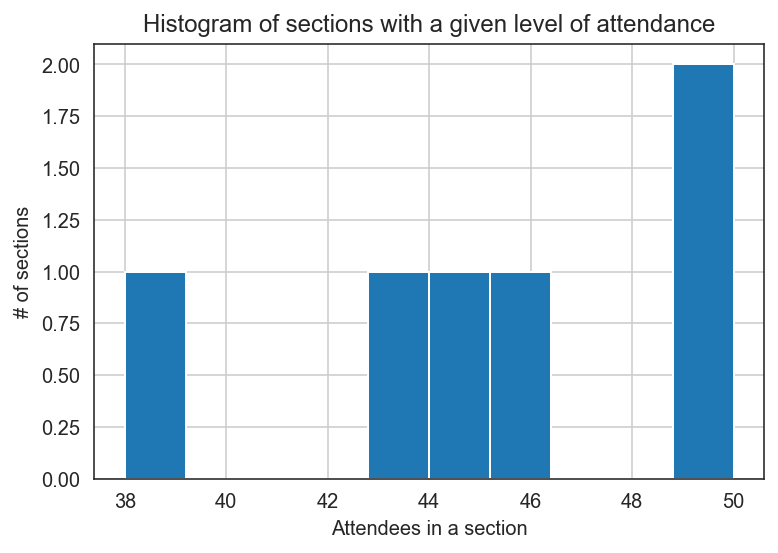

In [4]:
sections.hist();
plt.xlabel('Attendees in a section')
plt.ylabel('# of sections')
plt.title('Histogram of sections with a given level of attendance');

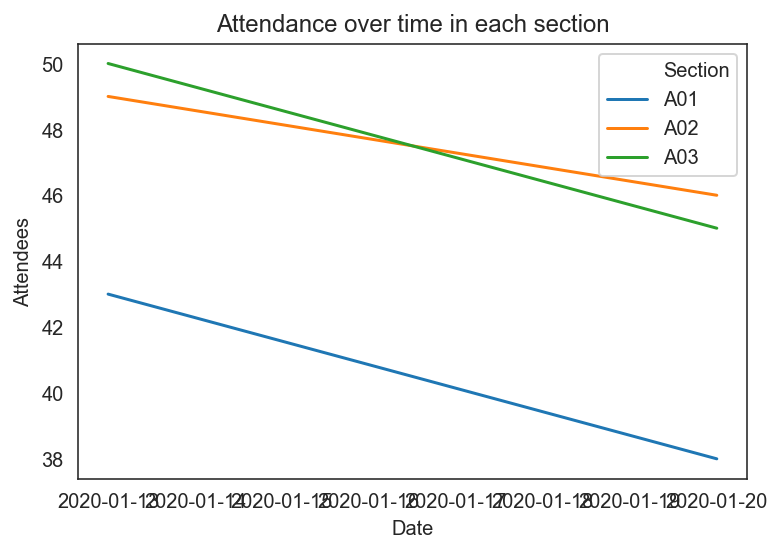

In [5]:
sns.lineplot( data=sections.reset_index(),
             x='Date',y='Attendees', hue='Section')
plt.title('Attendance over time in each section');


In [6]:
# this generates a report on how many dates somone attended discussion sections

individuals = individual_date_attendance_report(attendance)
individuals

,Dates attended
Name,
1,1
A,1
A(,1
AA,2
AB,2
...,...
YV,1
YX,2
ZG,1


In [7]:
# if you wanted to write out the attendance report to look at it inside Excel or something you can
individuals.to_excel('dates_attended.xlsx')

In [8]:
# this is how you could check who was there just for section A03 on Jan 13th
results = individual_attendance(attendance.loc['2020-01-13','A03',slice(None)])
results

Email            Join Time  \
Date       Section Name                                       
2020-01-13 A03     1     test@test.edu  01/13/2021 11:08:28   
                   A(    test@test.edu  01/13/2021 11:01:46   
                   AA    test@test.edu  01/13/2021 10:54:45   
                   AD    test@test.edu  01/13/2021 11:00:05   
                   AG    test@test.edu  01/13/2021 11:01:40   
                   AL    test@test.edu  01/13/2021 11:00:09   
                   AM    test@test.edu  01/13/2021 11:17:51   
                   AO    test@test.edu  01/13/2021 10:59:15   
                   AR    test@test.edu  01/13/2021 11:01:54   
                   AS    test@test.edu  01/13/2021 11:00:51   
                   BS    test@test.edu  01/13/2021 11:02:03   
                   BW    test@test.edu  01/13/2021 11:02:30   
                   CV    test@test.edu  01/13/2021 11:01:20   
                   DP    test@test.edu  01/13/2021 10:58:58   
                   GG    test@test.edu  01/13/2021 11:00:55   
                   ID    test@test.edu  01/13/2021 11:23:21   
                   JH    test@test.edu  01/13/2021 10:58:42   
                   JL    test@test.edu  01/13/2021 10:58:39   
                   JS    test@test.edu  01/13/2021 11:00:05   
                   JW    test@test.edu  01/13/2021 11:00:39   
                   KS    test@test.edu  01/13/2021 11:02:03   
                   LH    test@test.edu  01/13/2021 11:01:14   
                   LS    test@test.edu  01/13/2021 10:58:26   
                   M     test@test.edu  01/13/2021 10:57:15   
                   MC    test@test.edu  01/13/2021 11:00:23   
                   MK    test@test.edu  01/13/2021 10:58:23   
                   ML    test@test.edu  01/13/2021 11:00:08   
                   MS    test@test.edu  01/13/2021 11:04:30   
                   MT    test@test.edu  01/13/2021 10:59:20   
                   N     test@test.edu  01/13/2021 11:13:18   
                   OB    test@test.edu  01/13/2021 11:00:34   
                   RB    test@test.edu  01/13/2021 11:23:45   
                   RE    test@test.edu  01/13/2021 11:01:49   
                   SA    test@test.edu  01/13/2021 11:14:50   
                   SG    test@test.edu  01/13/2021 11:04:32   
                   SI    test@test.edu  01/13/2021 10:59:48   
                   SK    test@test.edu  01/13/2021 11:02:08   
                   SL    test@test.edu  01/13/2021 11:01:10   
                   SV    test@test.edu  01/13/2021 10:57:32   
                   SX    test@test.edu  01/13/2021 11:02:01   
                   TD    test@test.edu  01/13/2021 11:00:37   
                   TG    test@test.edu  01/13/2021 10:56:06   
                   TN    test@test.edu  01/13/2021 11:03:30   
                   TS    test@test.edu  01/13/2021 11:03:36   
                   US    test@test.edu  01/13/2021 11:00:26   
                   YQ    test@test.edu  01/13/2021 10:55:06   
                   YS    test@test.edu  01/13/2021 11:04:16   
                   YV    test@test.edu  01/13/2021 11:07:21   
                   YX    test@test.edu  01/13/2021 11:04:13   
                   t     test@test.edu  01/13/2021 11:23:28   

                                  Leave Time  Duration(Minutes)  In-n-outs  
Date       Section Name                                                     
2020-01-13 A03     1     01/13/2021 11:57:01               49.0          1  
                   A(    01/13/2021 11:57:05               56.0          3  
                   AA    01/13/2021 11:59:01               65.0          1  
                   AD    01/13/2021 11:56:53               59.0          3  
                   AG    01/13/2021 11:57:33               57.0          3  
                   AL    01/13/2021 11:56:48               58.0          3  
                   AM    01/13/2021 11:57:22               41.0          3  
                   AO    01/13/2021 11:56:57               60.0